# Analyze the alignement quality of our xenium patches

In [1]:
import os
import json
import io
import zipfile
import pandas as pd
import spatialdata as sd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba
from scipy.sparse import csr_matrix
import h5py

## Helper functions

In [2]:
def plot_all_metrics(df_metrics):

    metrics = ['Dice', 'Jaccard', 'bPQ']

    plt.figure(figsize=(9, 3))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df_metrics.loc[df_metrics["Dice"] != -1, metric], bins=30, kde=True, color='blue')
        plt.title(f'{metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [3]:
def load_imgfile(img_zip_path, img_name):
    with zipfile.ZipFile(img_zip_path, 'r') as img_zip:
        img_data = img_zip.read(img_name)
        img = Image.open(io.BytesIO(img_data))
    return np.array(img).astype(np.uint8)


def load_maskfile(mask_zip_path, mask_name):
        
    with zipfile.ZipFile(mask_zip_path, 'r') as mask_zip:
        
        with mask_zip.open(mask_name) as mask_file:
            # Load the .npz file using numpy
            data = np.load(io.BytesIO(mask_file.read()), allow_pickle=True)
            
            # Reconstruct sparse matrices
            inst_map_sparse = csr_matrix(
                (data["inst_map_data"], data["inst_map_indices"], data["inst_map_indptr"]),
                shape=data["inst_map_shape"]
            )
            type_map_sparse = csr_matrix(
                (data["type_map_data"], data["type_map_indices"], data["type_map_indptr"]),
                shape=data["type_map_shape"]
            )

            # Convert sparse matrices to dense arrays
            inst_map = inst_map_sparse.toarray().astype(np.int32)
            type_map = type_map_sparse.toarray().astype(np.int32)
    return inst_map, type_map

In [4]:
class H5FileSingleton:
    _instances = {}

    @classmethod
    def get_instance(cls, file_path):
        if file_path not in cls._instances:
            cls._instances[file_path] = h5py.File(file_path, 'r')
        return cls._instances[file_path]

    @classmethod
    def close_all(cls):
        for file_path, h5_file in cls._instances.items():
            if h5_file is not None:
                h5_file.close()
        cls._instances.clear()

In [5]:
def load_sparse_h5(file_path, image_name):
    """
    Load a sparse CSR matrix for a specific key (image_name) from a shared HDF5 file.
    
    Parameters:
        file_path (str): Path to the global HDF5 file.
        image_name (str): Key for the specific patch in the file.
    
    Returns:
        csr_matrix: Reconstructed sparse matrix.
    """
    h5_file = H5FileSingleton.get_instance(file_path)
    data = h5_file[f"{image_name}_data"][:]
    indices = h5_file[f"{image_name}_indices"][:]
    indptr = h5_file[f"{image_name}_indptr"][:]
    shape = tuple(h5_file[f"{image_name}_shape"][:])  # Ensure shape is a tuple
    return csr_matrix((data, indices, indptr), shape=shape)

In [6]:
def plot_check_seg(df_metrics, metric, low_threshold, high_threshold, n_plot, img_zip_path, mask_zip_path, inst_map_pred_path, save_folder=None):

    patch_ids_selected = df_metrics.loc[(df_metrics[metric] > low_threshold) & (df_metrics[metric] < high_threshold), "patch_id"]

    patch_ids = patch_ids_selected.sample(min(n_plot, len(patch_ids_selected)))

    for id in patch_ids:

        row = df_metrics[df_metrics['patch_id'] == id].iloc[0]
        dice_score = row['Dice']
        jaccard_score = row['Jaccard']
        pq_score = row['bPQ']

        # Our mask from ST
        inst_map, type_map = load_maskfile(mask_zip_path, f"{id}.npz")

        unique_objects = np.unique(inst_map)[np.unique(inst_map) != 0]  # Exclude the background (0)
        num_objects = len(unique_objects)
        cmap = plt.get_cmap('hsv', num_objects)
        idx2color_mask = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
        idx2color_mask[0] = (0, 0, 0, 0)  # Transparent background for value 0

        # H&E patch
        image = load_imgfile(img_zip_path, f"{id}.png")

        # The predicted segmentation
        inst_map_pred = load_sparse_h5(inst_map_pred_path, f"{id}")
        inst_map_pred = inst_map_pred.toarray().astype(np.int32)

        unique_objects = np.unique(inst_map_pred)[np.unique(inst_map_pred) != 0]  # Exclude the background (0)
        num_objects = len(unique_objects)
        cmap = plt.get_cmap('hsv', num_objects)
        idx2color_pred = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
        idx2color_pred[0] = (0, 0, 0, 0)  # Transparent background for value 0

        plt.figure(figsize=(5, 2))
        # Plot H&E patch
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title(f'Patch{id}')
        # Plot H&E patch with mask
        plt.subplot(1,3,2)
        plt.imshow(image)
        mask_plotting = np.array([[idx2color_mask[idx] for idx in row] for row in inst_map])
        plt.imshow(mask_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('From ST')
        # Plot H&E patch with predicted mask
        plt.subplot(1,3,3)
        plt.imshow(image)
        pred_plotting = np.array([[idx2color_pred[idx] for idx in row] for row in inst_map_pred])
        plt.imshow(pred_plotting, alpha=0.4)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.title('CellViT prediction')

        plt.figtext(0.5, 0.02, f'Dice: {dice_score:.3f}, Jaccard: {jaccard_score:.3f}, bPQ: {pq_score:.3f}', 
                    wrap=True, horizontalalignment='center', fontsize=10)
        
        plt.tight_layout()

        if save_folder:
            plt.savefig(os.path.join(save_folder, f'{id}_{metric}-{row[metric]}.png'), dpi=300)

        plt.show()

In [7]:
def plot_patch_seg(patch_id, df_metrics, img_zip_path, mask_zip_path, inst_map_pred_path, save_folder=None):

    row = df_metrics[df_metrics['patch_id'] == patch_id].iloc[0]
    dice_score = row['Dice']
    jaccard_score = row['Jaccard']
    pq_score = row['bPQ']

    # Our mask from ST
    inst_map, type_map = load_maskfile(mask_zip_path, f"{patch_id}.npz")

    unique_objects = np.unique(inst_map)[np.unique(inst_map) != 0]  # Exclude the background (0)
    num_objects = len(unique_objects)
    cmap = plt.get_cmap('hsv', num_objects)
    idx2color_mask = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
    idx2color_mask[0] = (0, 0, 0, 0)  # Transparent background for value 0

    # H&E patch
    image = load_imgfile(img_zip_path, f"{patch_id}.png")

    # The predicted segmentation
    inst_map_pred = load_sparse_h5(inst_map_pred_path, f"{patch_id}")
    inst_map_pred = inst_map_pred.toarray().astype(np.int32)

    unique_objects = np.unique(inst_map_pred)[np.unique(inst_map_pred) != 0]  # Exclude the background (0)
    num_objects = len(unique_objects)
    cmap = plt.get_cmap('hsv', num_objects)
    idx2color_pred = {obj: to_rgba(cmap(i), alpha=1.0) for i, obj in enumerate(unique_objects, start=1)}
    idx2color_pred[0] = (0, 0, 0, 0)  # Transparent background for value 0

    plt.figure(figsize=(5, 2))
    # Plot H&E patch
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title(f'Patch{patch_id}')
    # Plot H&E patch with mask
    plt.subplot(1,3,2)
    plt.imshow(image)
    mask_plotting = np.array([[idx2color_mask[idx] for idx in row] for row in inst_map])
    plt.imshow(mask_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('From ST')
    # Plot H&E patch with predicted mask
    plt.subplot(1,3,3)
    plt.imshow(image)
    pred_plotting = np.array([[idx2color_pred[idx] for idx in row] for row in inst_map_pred])
    plt.imshow(pred_plotting, alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=6)
    plt.title('CellViT prediction')

    plt.figtext(0.5, 0.02, f'Dice: {dice_score:.3f}, Jaccard: {jaccard_score:.3f}, bPQ: {pq_score:.3f}', 
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.tight_layout()

    if save_folder:
        plt.savefig(os.path.join(save_folder, f'{patch_id}_check_seg.png'), dpi=300)

    plt.show()

In [8]:
output_cellvit_folder = '/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/check_align_patches/apply_cellvit/output_cellvit'
patches_xenium_folder = '/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/check_align_patches/apply_cellvit/prepared_patches_xenium'

sdata_folder = '/Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final'

## All slides (except brain_0, bone_marrow_s0, bone_marrow_s1 and bone_s0)

In [2]:
def plot_all_metrics(df_metrics):

    metrics = ['Dice', 'Jaccard', 'bPQ']

    plt.figure(figsize=(9, 3))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df_metrics.loc[df_metrics["Dice"] != -1, metric], bins=30, kde=True, color='#6e7f94')
        plt.title(f'{metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [3]:
df_metrics = pd.read_csv('/Volumes/DD1_FGS/MICS/data_HE2CellType/HE2CT/prepared_datasets_cat/ct_1/ALL/patch_metrics.csv')
df_metrics

patch_id      Dice   Jaccard       bPQ
0          heart_s0_312.png  0.000000  0.000000  0.000000
1          heart_s0_313.png  0.000000  0.000000  0.000000
2          heart_s0_358.png  0.556122  0.385159  0.347687
3          heart_s0_359.png  0.000000  0.000000  0.000000
4          heart_s0_362.png  0.777565  0.636079  0.480884
...                     ...       ...       ...       ...
587550  cervix_s0_46420.png  0.698644  0.536859  0.375538
587551  cervix_s0_46421.png  0.730785  0.575777  0.446292
587552  cervix_s0_46422.png  0.749292  0.599094  0.390617
587553  cervix_s0_46423.png  0.551789  0.381014  0.142830
587554  cervix_s0_46424.png  0.000000  0.000000  0.000000

[587555 rows x 4 columns]

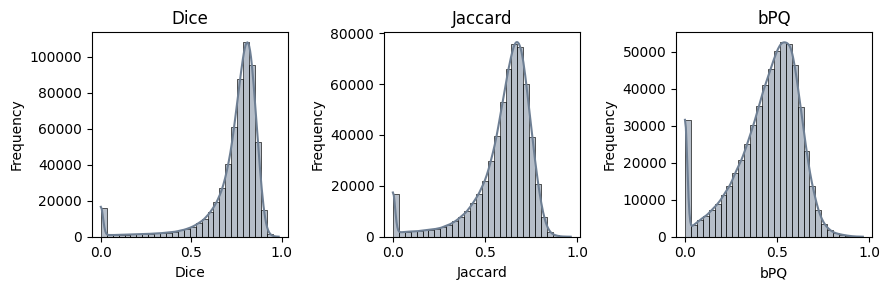

In [4]:
plot_all_metrics(df_metrics)

## Analyze for breast_s0

In [9]:
slide_id = "breast_s0"

In [10]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_breast_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (576963, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (70812, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (576963, 1) (2D shapes)
with coordinate systems:
    ▸ '_13260553376_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

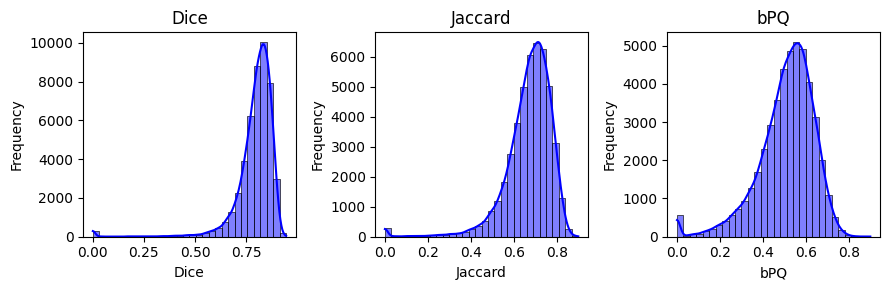

In [11]:
plot_all_metrics(sdata.shapes['he_patches'])

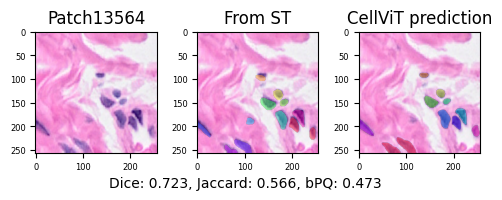

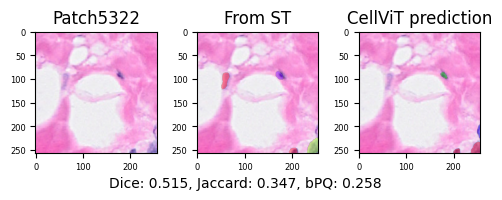

In [12]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for breast_s1

In [14]:
slide_id = "breast_s1"

In [15]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_breast_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (892966, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (149544, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (892966, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

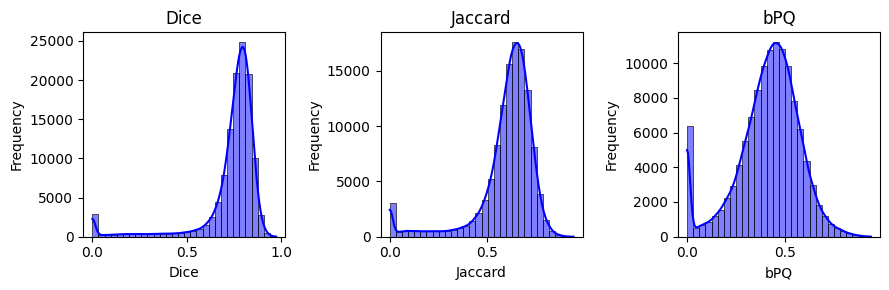

In [16]:
plot_all_metrics(sdata.shapes['he_patches'])

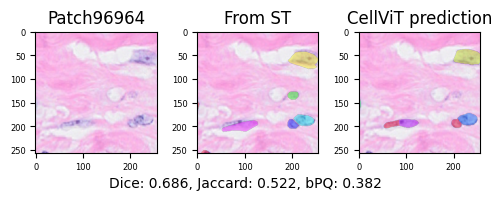

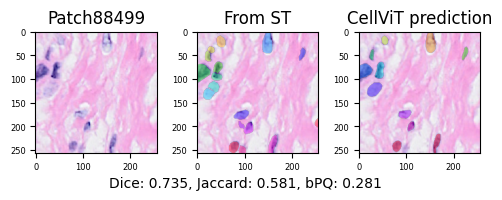

In [17]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for breast_s3

In [18]:
slide_id = "breast_s3"

In [19]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_breast_s3.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (365604, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (51408, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (365604, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

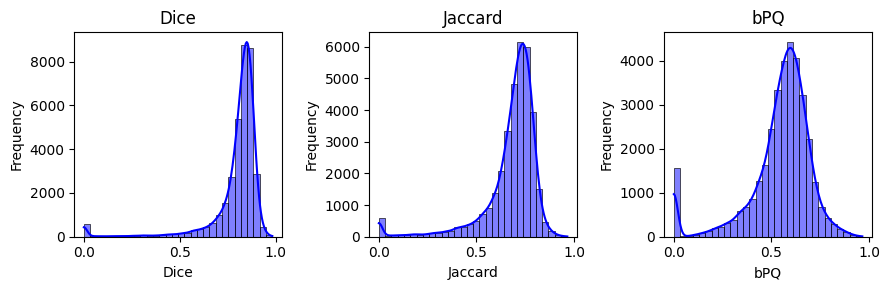

In [20]:
plot_all_metrics(sdata.shapes['he_patches'])

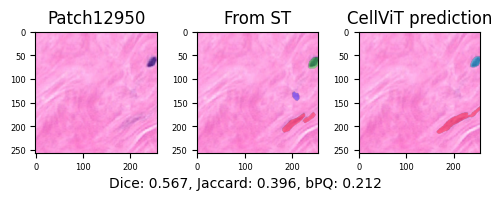

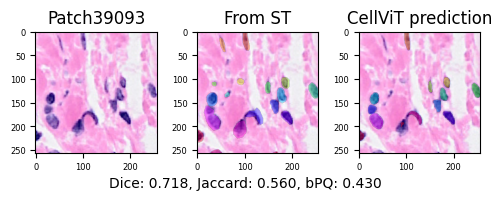

In [21]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for breast_s6

In [22]:
slide_id = "breast_s6"

In [23]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_breast_s6.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (692184, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (58305, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (692184, 1) (2D shapes)
with coordinate systems:
    ▸ '_13828841792_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

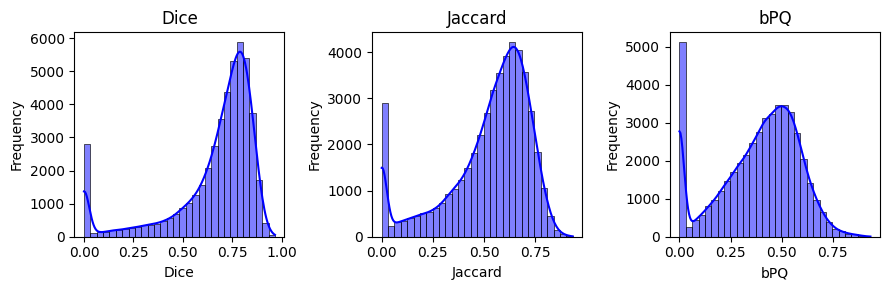

In [24]:
plot_all_metrics(sdata.shapes['he_patches'])

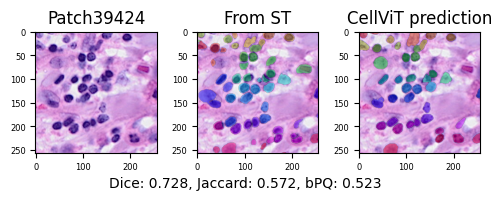

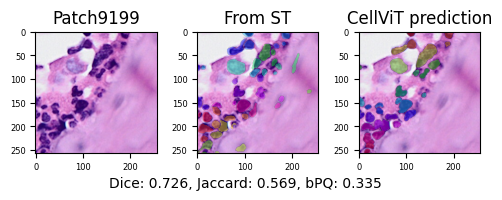

In [25]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for lung_s1

In [26]:
slide_id = "lung_s1"

In [27]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_lung_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (161000, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (16605, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (161000, 1) (2D shapes)
with coordinate systems:
    ▸ '_13914882112_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

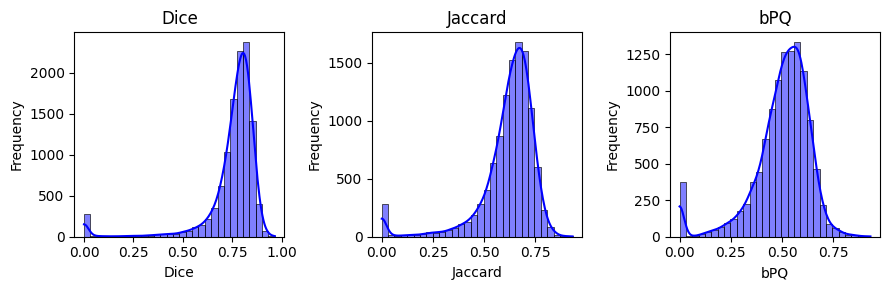

In [28]:
plot_all_metrics(sdata.shapes['he_patches'])

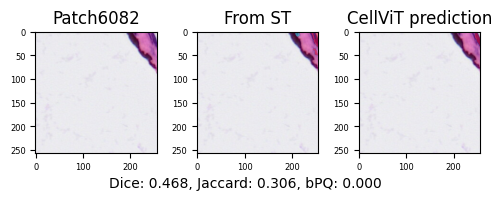

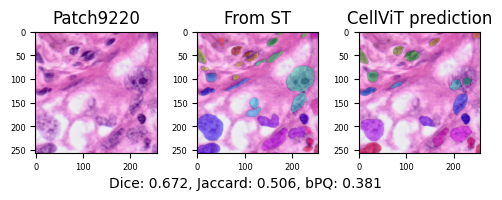

In [29]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for lung_s3

In [30]:
slide_id = "lung_s3"

In [31]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_lung_s3.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (275207, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (31414, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (275207, 1) (2D shapes)
with coordinate systems:
    ▸ '_6103280576_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

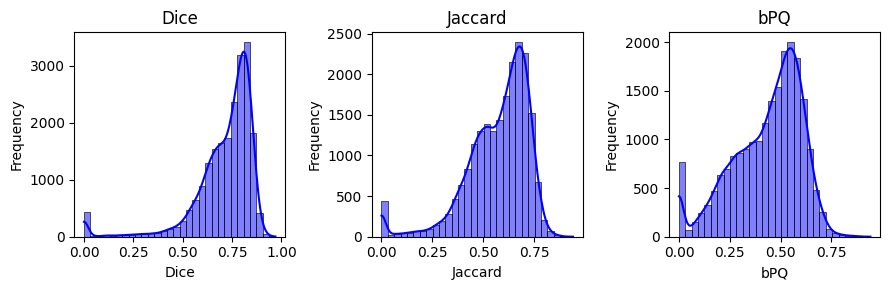

In [32]:
plot_all_metrics(sdata.shapes['he_patches'])

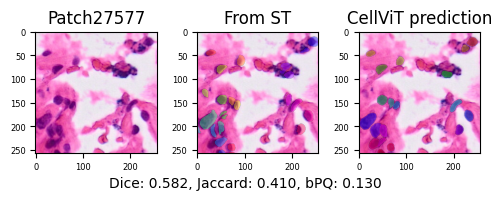

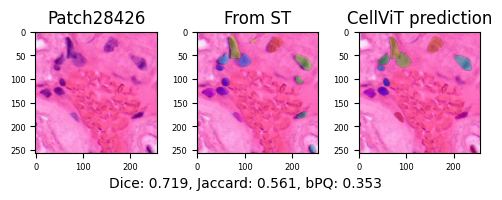

In [33]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for skin_s1

In [34]:
slide_id = "skin_s1"

In [35]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_skin_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (90106, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (17325, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (90106, 1) (2D shapes)
with coordinate systems:
    ▸ '_13982591840_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

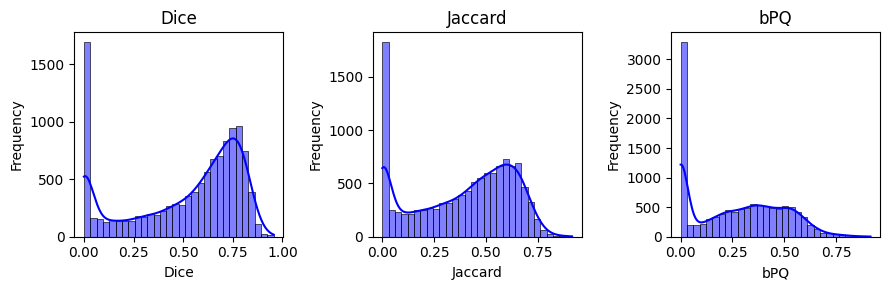

In [36]:
plot_all_metrics(sdata.shapes['he_patches'])

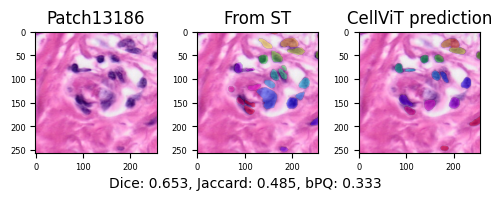

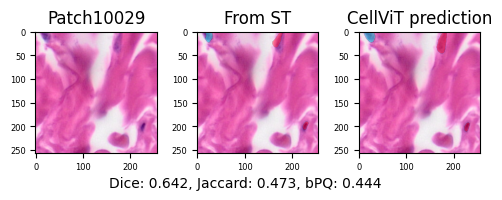

In [37]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for skin_s2

In [38]:
slide_id = "skin_s2"

In [39]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_skin_s2.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (26216, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (87499, 1) (2D shapes)
with coordinate systems:
    ▸ '_13931763680_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

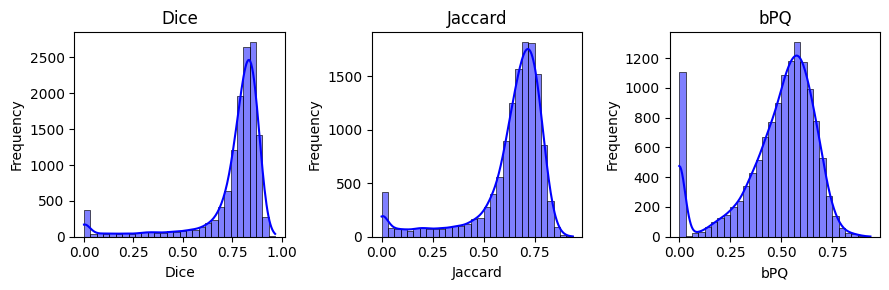

In [40]:
plot_all_metrics(sdata.shapes['he_patches'])

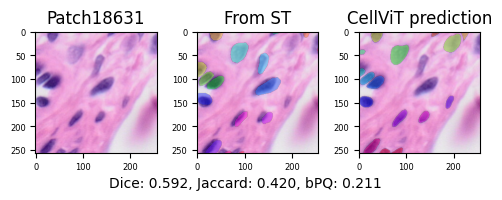

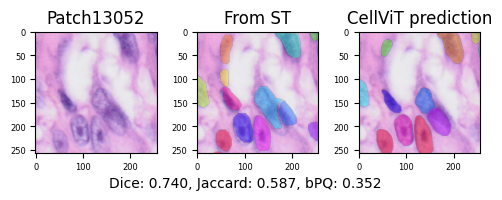

In [41]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for skin_s3

In [42]:
slide_id = "skin_s3"

In [43]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_skin_s3.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (106980, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (12508, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (106980, 1) (2D shapes)
with coordinate systems:
    ▸ '_14634003296_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

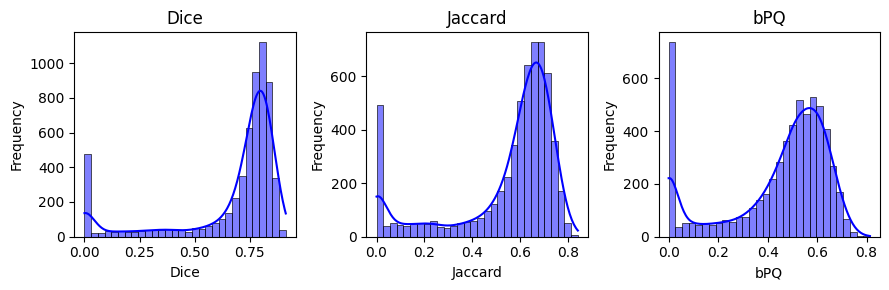

In [44]:
plot_all_metrics(sdata.shapes['he_patches'])

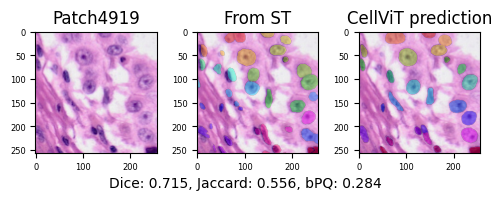

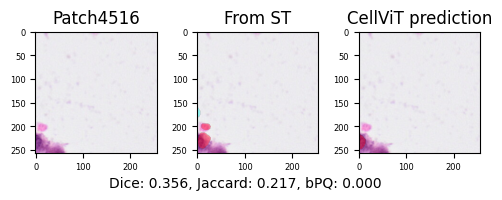

In [45]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for skin_s4

In [46]:
slide_id = "skin_s4"

In [47]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_skin_s4.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (109795, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (18139, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (109795, 1) (2D shapes)
with coordinate systems:
    ▸ '_6068357536_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

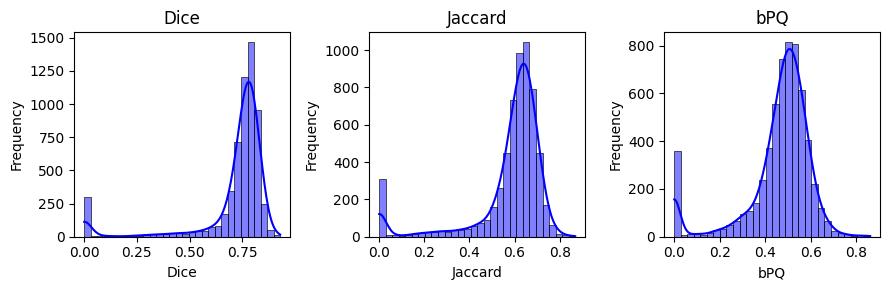

In [48]:
plot_all_metrics(sdata.shapes['he_patches'])

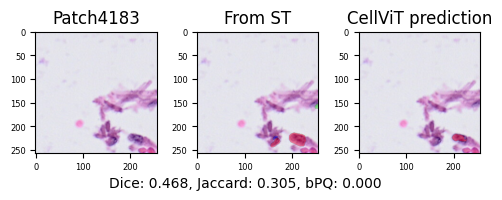

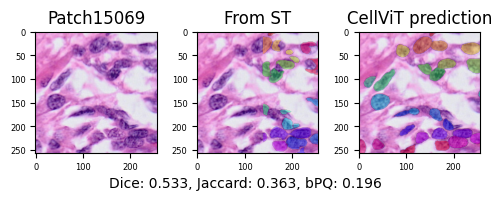

In [49]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for pancreatic_s0

In [50]:
slide_id = "pancreatic_s0"

In [51]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_pancreatic_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (40125, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
with coordinate systems:
    ▸ '_13384296640_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

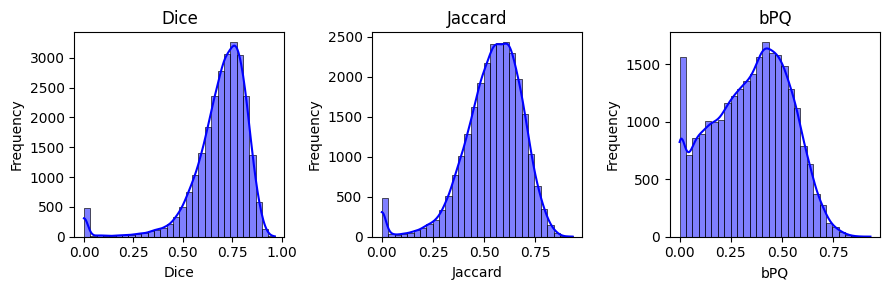

In [52]:
plot_all_metrics(sdata.shapes['he_patches'])

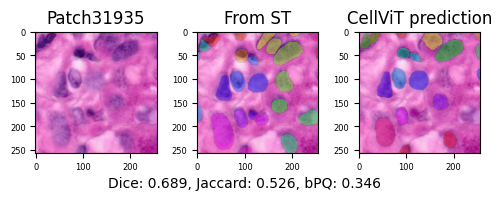

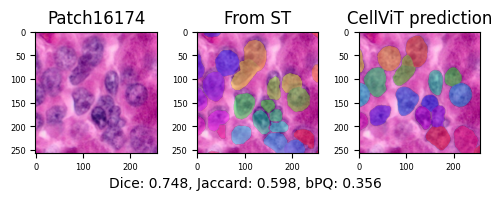

In [53]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for pancreatic_s1

In [54]:
slide_id = "pancreatic_s1"

In [55]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_pancreatic_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (235099, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (21186, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (235099, 1) (2D shapes)
with coordinate systems:
    ▸ '_6092994112_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

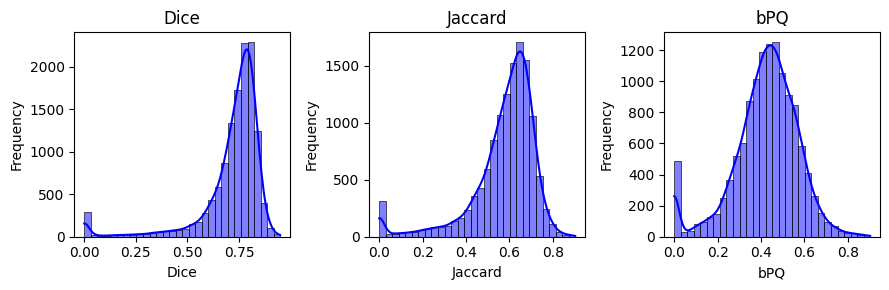

In [56]:
plot_all_metrics(sdata.shapes['he_patches'])

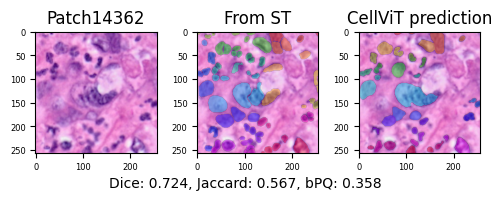

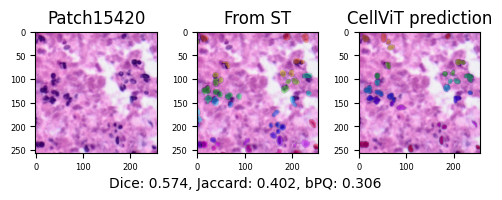

In [57]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for pancreatic_s2

In [58]:
slide_id = "pancreatic_s2"

In [59]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_pancreatic_s2.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (136531, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (11154, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (136531, 1) (2D shapes)
with coordinate systems:
    ▸ '_6163788608_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

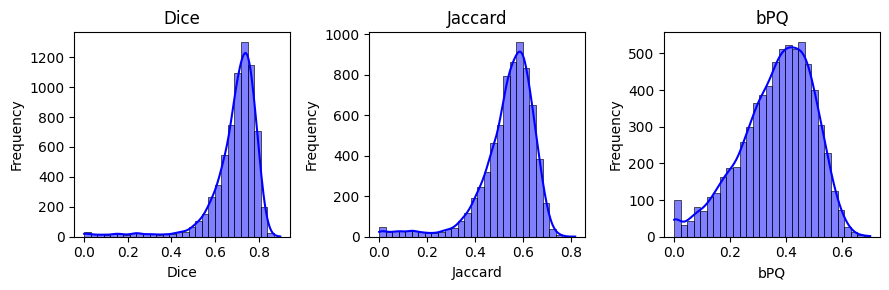

In [60]:
plot_all_metrics(sdata.shapes['he_patches'])

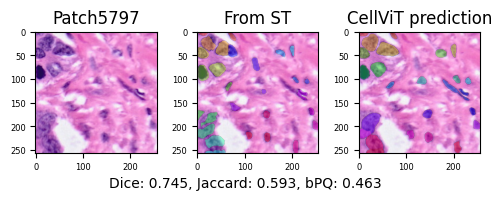

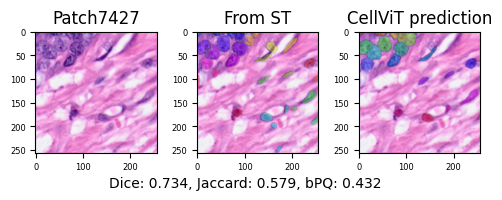

In [61]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for heart_s0

In [62]:
slide_id = "heart_s0"

In [63]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_heart_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (26366, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (7168, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (26366, 1) (2D shapes)
with coordinate systems:
    ▸ '_13531419104_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ features_phikonv2 (Tables)
    ▸ features_cellvit (Tables)
    ▸ features_vit_google (Tables)
    ▸ table_scvi (Tables)
    ▸ he (Images)

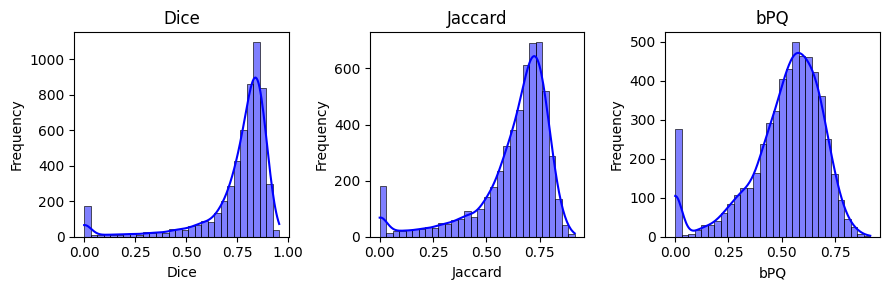

In [64]:
plot_all_metrics(sdata.shapes['he_patches'])

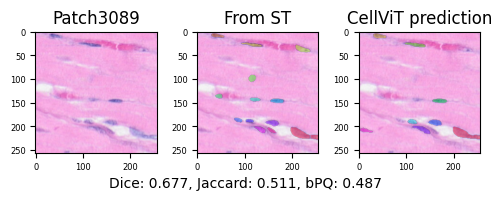

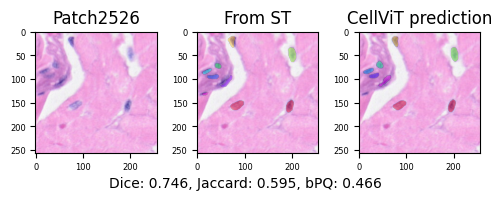

In [65]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for colon_s1

In [66]:
slide_id = "colon_s1"

In [67]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_colon_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (587115, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (31500, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (587115, 1) (2D shapes)
with coordinate systems:
    ▸ '_13696212736_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

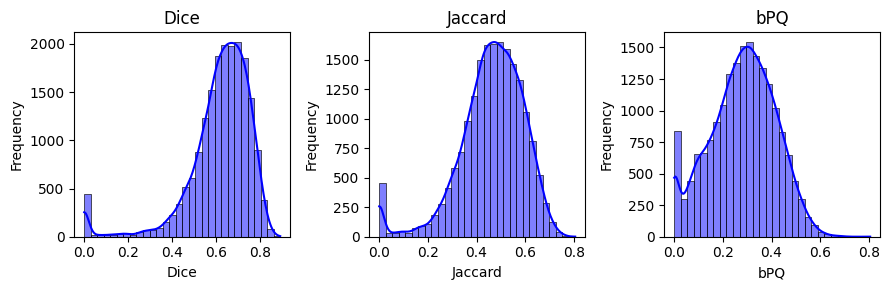

In [68]:
plot_all_metrics(sdata.shapes['he_patches'])

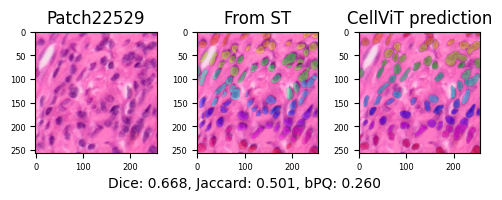

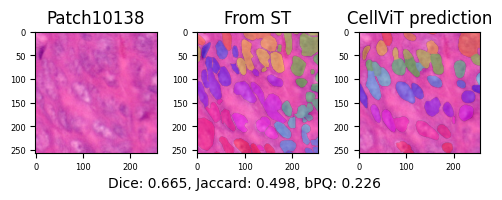

In [69]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for colon_s2

In [70]:
slide_id = "colon_s1"

In [71]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_colon_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (587115, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (31500, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (587115, 1) (2D shapes)
with coordinate systems:
    ▸ '_13696212736_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

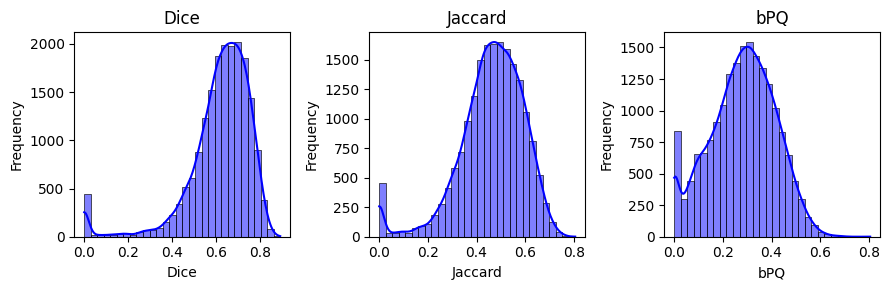

In [72]:
plot_all_metrics(sdata.shapes['he_patches'])

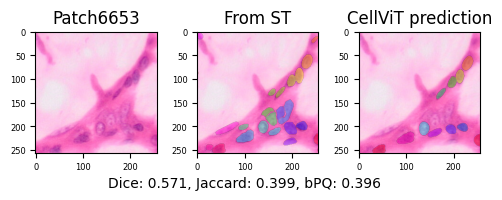

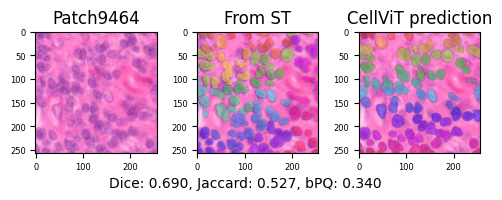

In [73]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for kidney_s0

In [74]:
slide_id = "kidney_s0"

In [75]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_kidney_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (97560, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (10788, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (97560, 1) (2D shapes)
with coordinate systems:
    ▸ '_13810502528_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

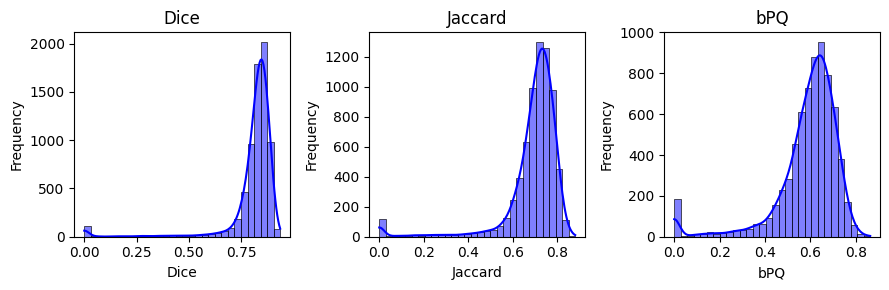

In [76]:
plot_all_metrics(sdata.shapes['he_patches'])

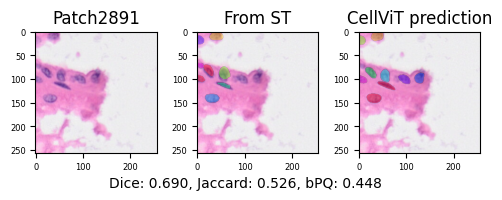

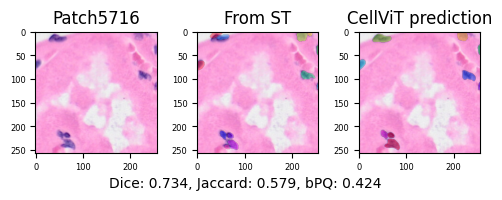

In [77]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for kidney_s1

In [78]:
slide_id = "kidney_s1"

In [79]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_kidney_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (56510, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (6532, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (56510, 1) (2D shapes)
with coordinate systems:
    ▸ '_14003981952_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

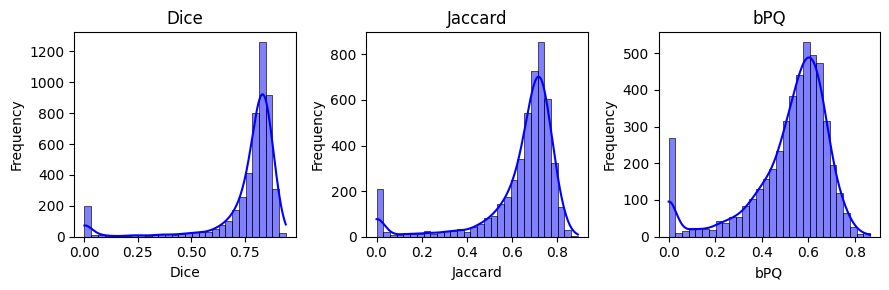

In [80]:
plot_all_metrics(sdata.shapes['he_patches'])

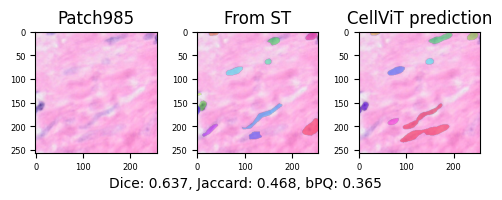

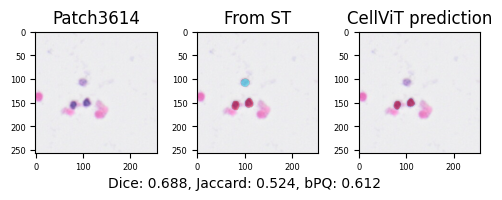

In [81]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for liver_s0

In [82]:
slide_id = "liver_s0"

In [83]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_liver_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (239271, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (32487, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (239271, 1) (2D shapes)
with coordinate systems:
    ▸ '_13515697760_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

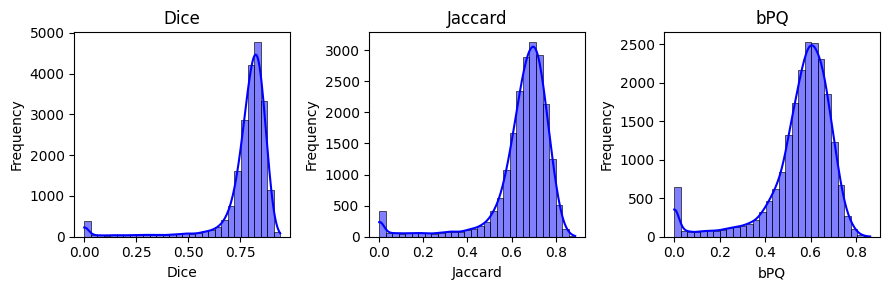

In [84]:
plot_all_metrics(sdata.shapes['he_patches'])

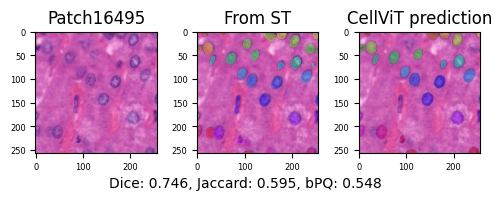

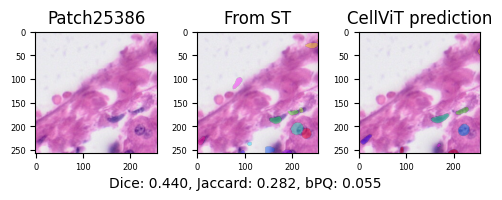

In [85]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for liver_s1

In [89]:
slide_id = "liver_s1"

In [90]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_liver_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (162628, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (14080, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (162628, 1) (2D shapes)
with coordinate systems:
    ▸ '_13891798208_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

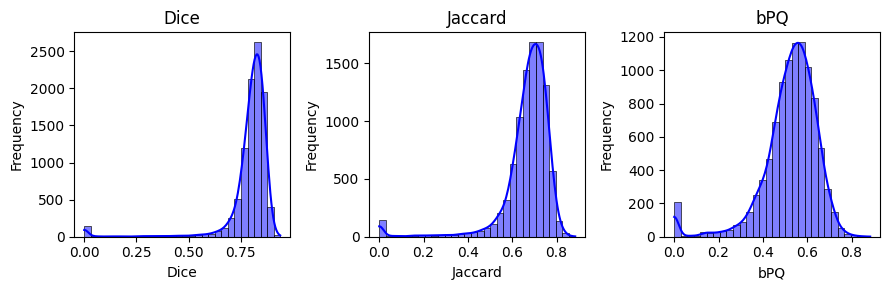

In [91]:
plot_all_metrics(sdata.shapes['he_patches'])

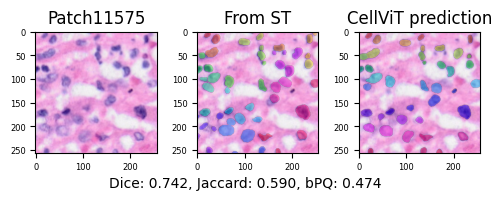

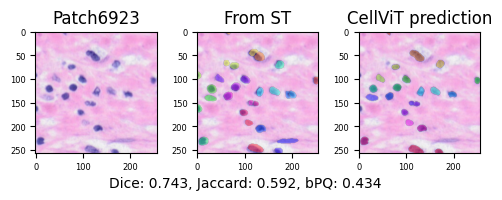

In [92]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for tonsil_s0

In [93]:
slide_id = "tonsil_s0"

In [94]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_tonsil_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (1349620, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (35916, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (1349620, 1) (2D shapes)
with coordinate systems:
    ▸ '_13730804256_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

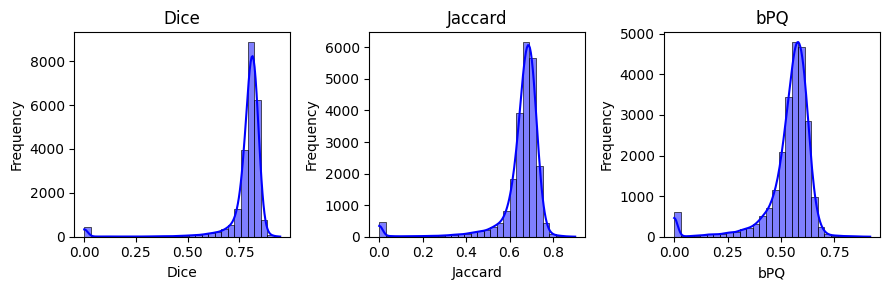

In [95]:
plot_all_metrics(sdata.shapes['he_patches'])

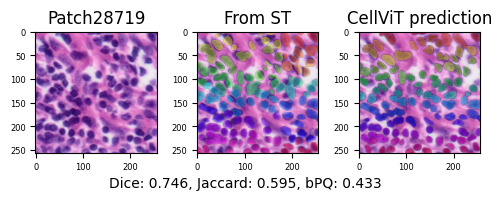

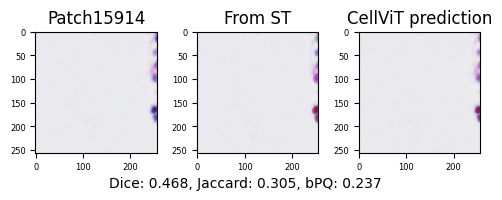

In [96]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for tonsil_s1

In [97]:
slide_id = "tonsil_s1"

In [98]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_tonsil_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (864388, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (43719, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (864388, 1) (2D shapes)
with coordinate systems:
    ▸ '_13591744800_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

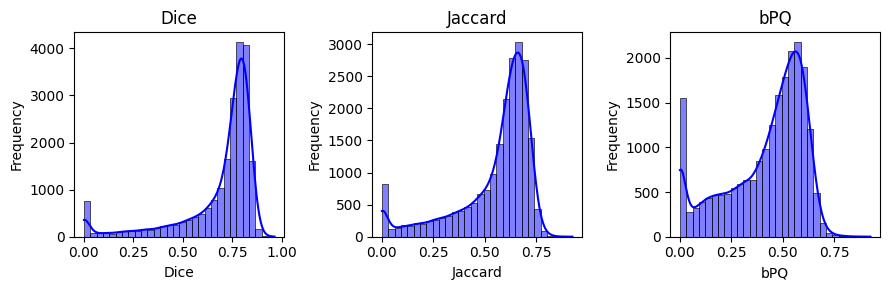

In [99]:
plot_all_metrics(sdata.shapes['he_patches'])

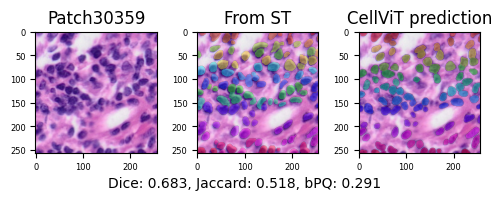

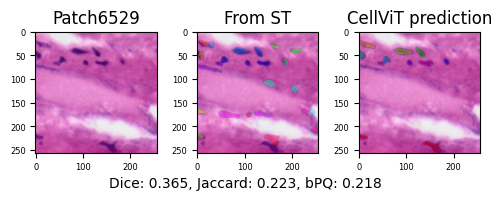

In [100]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for lymph_node_s0

In [101]:
slide_id = "lymph_node_s0"

In [102]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_lymph_node_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (702300, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (24462, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (702300, 1) (2D shapes)
with coordinate systems:
    ▸ '_6067809408_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

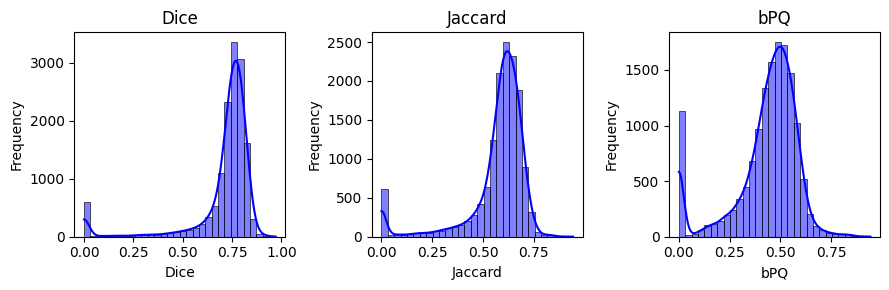

In [103]:
plot_all_metrics(sdata.shapes['he_patches'])

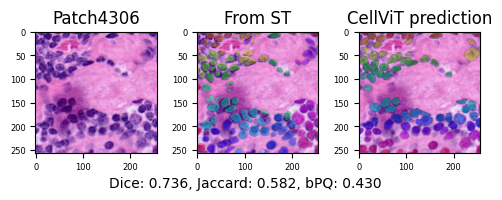

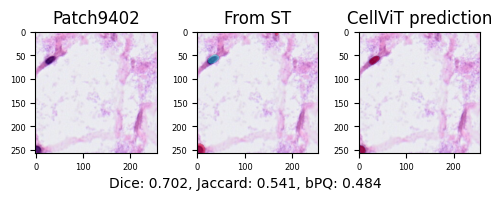

In [104]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for ovary_s0

In [105]:
slide_id = "ovary_s0"

In [106]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_ovary_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (247636, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (22230, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (247636, 1) (2D shapes)
with coordinate systems:
    ▸ '_13421471936_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

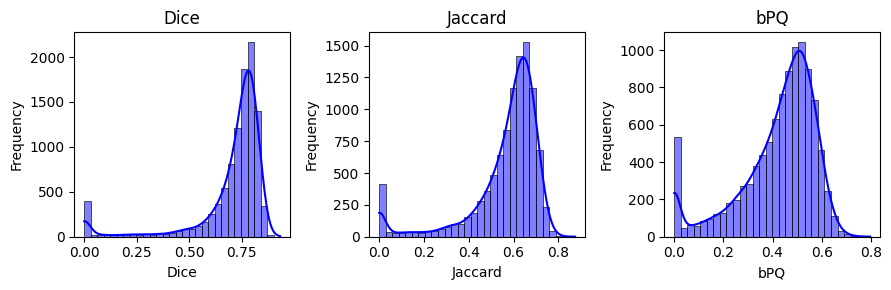

In [107]:
plot_all_metrics(sdata.shapes['he_patches'])

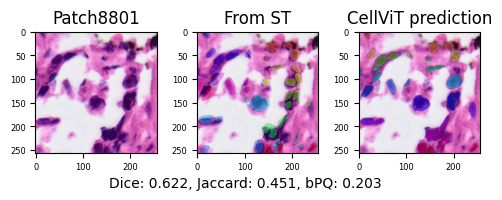

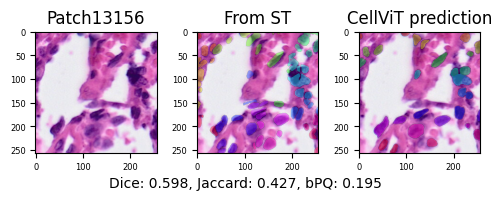

In [108]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for ovary_s1

In [109]:
slide_id = "ovary_s1"

In [110]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_ovary_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (401404, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (36869, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (401404, 1) (2D shapes)
with coordinate systems:
    ▸ '_21646880544_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

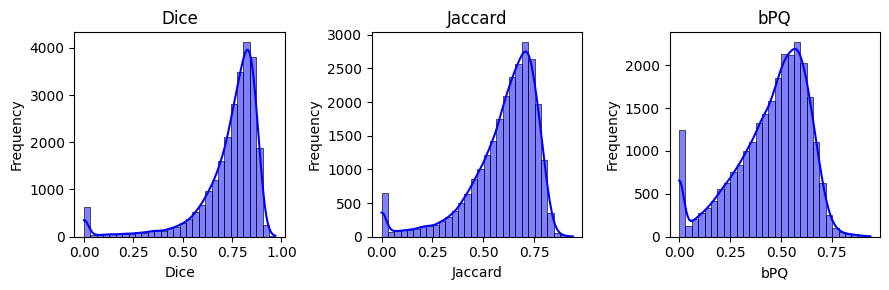

In [111]:
plot_all_metrics(sdata.shapes['he_patches'])

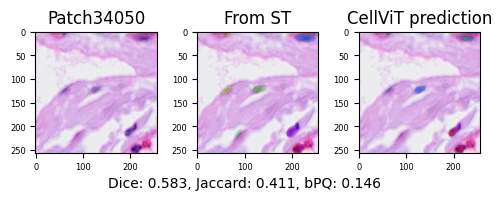

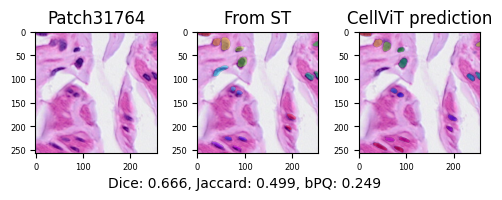

In [112]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for brain_s0

In [113]:
slide_id = "brain_s0"

In [114]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_brain_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (809076, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (61915, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (809076, 1) (2D shapes)
with coordinate systems:
    ▸ '_20199177376_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

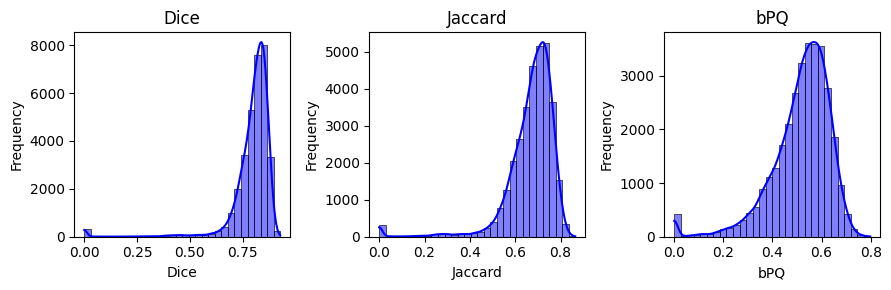

In [115]:
plot_all_metrics(sdata.shapes['he_patches'])

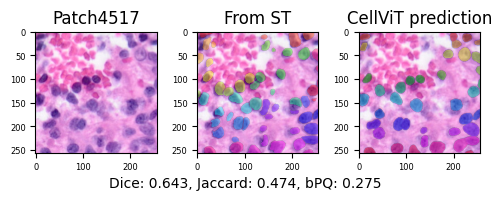

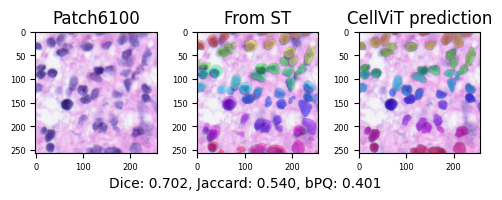

In [116]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for bone_marrow_s0

In [117]:
slide_id = "bone_marrow_s0"

In [118]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_bone_marrow_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (225906, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (11252, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (225906, 1) (2D shapes)
with coordinate systems:
    ▸ '_13951041696_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

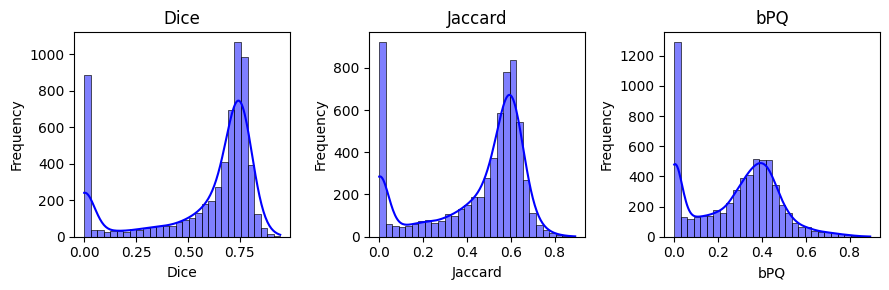

In [119]:
plot_all_metrics(sdata.shapes['he_patches'])

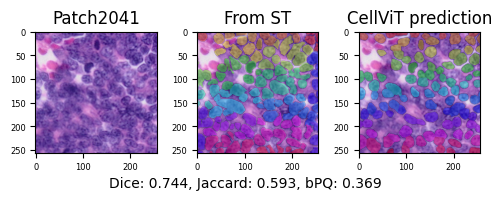

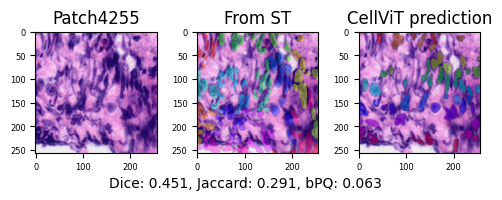

In [120]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for bone_marrow_s1

In [121]:
slide_id = "bone_marrow_s1"

In [122]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_bone_marrow_s1.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (84518, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (13680, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (84518, 1) (2D shapes)
with coordinate systems:
    ▸ '_14165953984_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

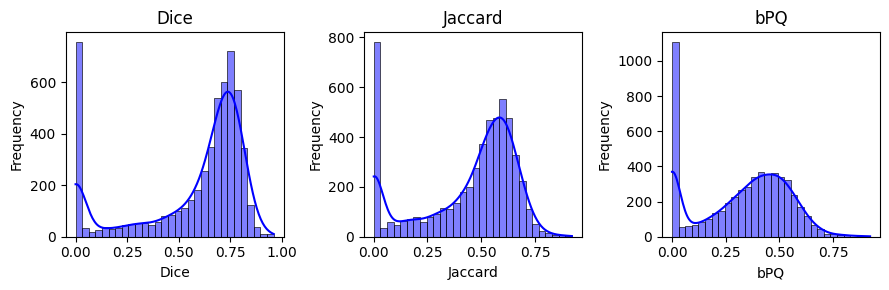

In [123]:
plot_all_metrics(sdata.shapes['he_patches'])

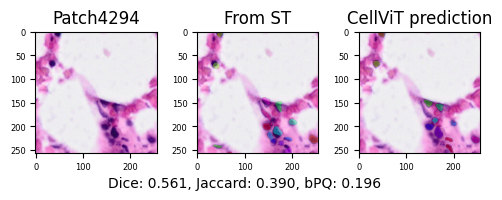

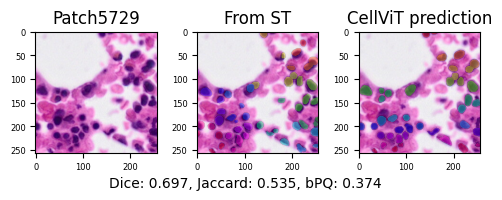

In [124]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for bone_s0

In [125]:
slide_id = "bone_s0"

In [126]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_bone_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (33801, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (34028, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (33801, 1) (2D shapes)
with coordinate systems:
    ▸ '_13889163456_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

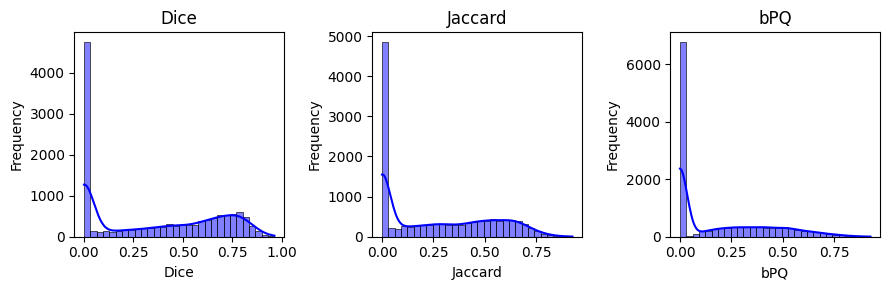

In [127]:
plot_all_metrics(sdata.shapes['he_patches'])

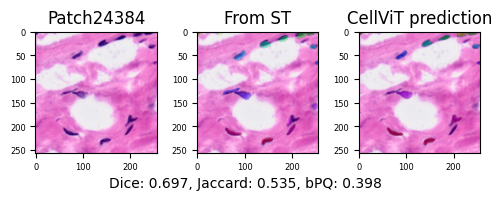

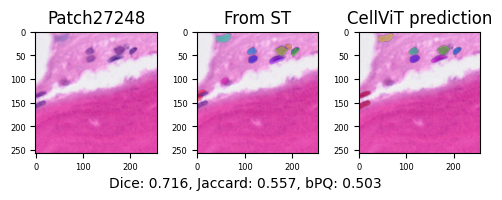

In [128]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for prostate_s0

In [129]:
slide_id = "prostate_s0"

In [130]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_prostate_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (184853, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (33800, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (184853, 1) (2D shapes)
with coordinate systems:
    ▸ '_13441420832_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

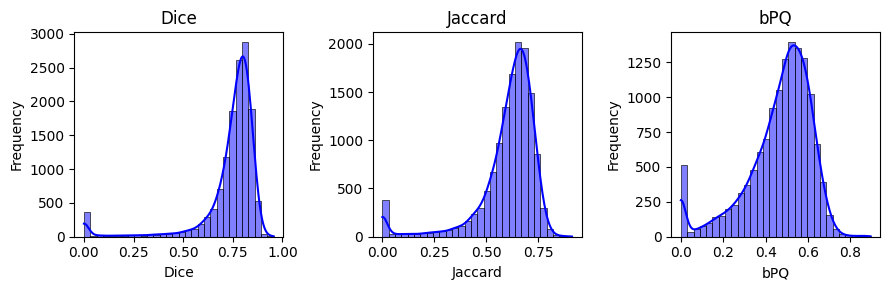

In [131]:
plot_all_metrics(sdata.shapes['he_patches'])

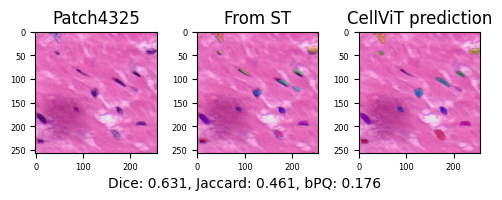

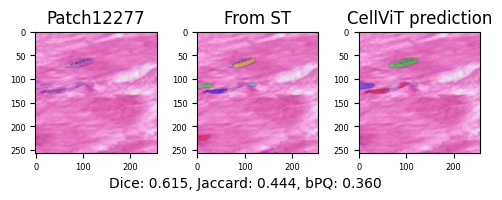

In [132]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

## Analyze for cervix_s0

In [133]:
slide_id = "cervix_s0"

In [134]:
sdata_path = os.path.join(sdata_folder, f'sdata_{slide_id}.zarr')
sdata = sd.read_zarr(sdata_path, selection=('shapes',))
sdata

SpatialData object, with associated Zarr store: /Volumes/SAUV_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_cervix_s0.zarr
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (825663, 1) (2D shapes)
      ├── 'he_patches': GeoDataFrame shape: (48357, 7) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (825663, 1) (2D shapes)
with coordinate systems:
    ▸ '_14178538624_intrinsic', with elements:
        he_patches (Shapes)
    ▸ 'global', with elements:
        cell_boundaries (Shapes), he_patches (Shapes), nucleus_boundaries (Shapes)
with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_nuclei (Tables)
    ▸ st (Points)
    ▸ table_cells (Tables)
    ▸ morpho (Images)
    ▸ table_scvi (Tables)
    ▸ he (Images)

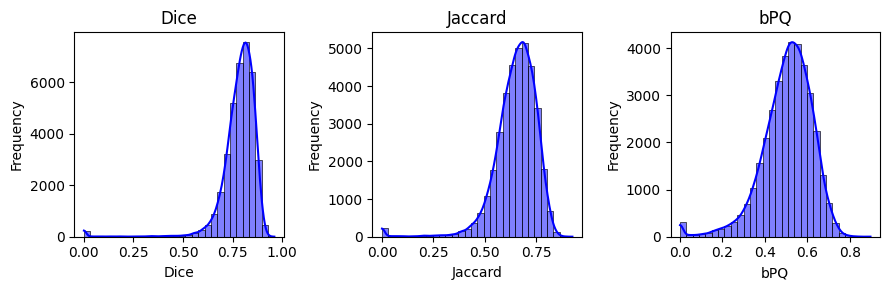

In [135]:
plot_all_metrics(sdata.shapes['he_patches'])

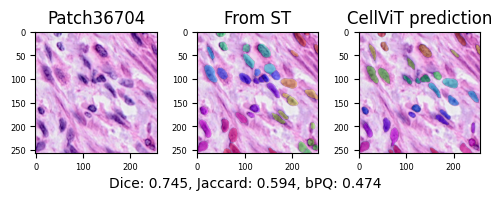

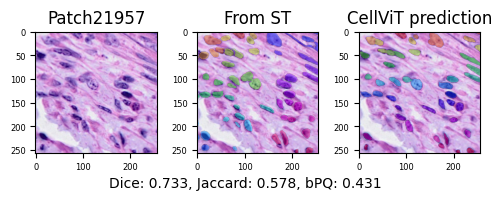

In [136]:
plot_check_seg(df_metrics=sdata.shapes['he_patches'], 
            metric='Jaccard', 
            low_threshold=0.2, 
            high_threshold=0.6, 
            n_plot=2,
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)

In [ ]:
plot_patch_seg(patch_id=486, 
            df_metrics=sdata.shapes['he_patches'], 
            img_zip_path=os.path.join(patches_xenium_folder, slide_id, 'images.zip'),
            mask_zip_path=os.path.join(patches_xenium_folder, slide_id, 'labels.zip'),
            inst_map_pred_path=os.path.join(output_cellvit_folder, slide_id, 'inference_instance_map_predictions.h5'),
            save_folder=None)